In [1]:
import time
import win32gui
import numpy as np

import mss
import mss.tools
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from cloningCNN import CloningCNN, ResNet

from torch.distributions import Categorical

from pynput.keyboard import Key, Controller
import matplotlib.pyplot as plt

# Define RL environment for the game window

In [2]:
class GameEnv:
    def __init__(self, windowName, inputInterval, usingResNet=False):
        self.gameBbox = self.getWindowBbox(windowName)
        self.capper = mss.mss()
        self.capNum = 0
        self.downsamplingMethod = Image.NEAREST
        self.usingResNet = usingResNet
        
        self.captureWindow = None
        self.prevGoldPixels = None
        
        self.keyboard = Controller()
        self.keyCodes = {0:Key.up, 1:Key.right, 2:Key.down, 3:Key.left}
        self.inputInterval = inputInterval
        
    def getWindowBbox(self, windowName):
        gameWindow = win32gui.FindWindow(None, windowName)
        if gameWindow == 0:
            print("Could not find game window for \"" + windowName + "\". Exiting.")
            exit()
        
        bbox = list(win32gui.GetWindowRect(gameWindow))
        # fix idiosyncrasies of win32gui window rect acquisition
        bbox[0] += 8
        bbox[1] += 31
        width = bbox[2]-bbox[0]
        height = bbox[3]-bbox[1]
        # return a 'monitor' object in the format that the mss library wants
        return {'top': bbox[1], 'left': bbox[0], 'width': width-8, 'height': height-8}
    
    def quickRestart(self):
        for key in [Key.esc, Key.up, Key.up, Key.up, Key.right]:
            self.keyboard.press(key)
            self.keyboard.release(key)
            time.sleep(0.1)
        time.sleep(2)
    
    def reset(self):
        self.quickRestart()
        initScreen, initGoldPixels, lvlDone, heartPixels = self.getScreenInfo()
        self.prevGoldPixels = initGoldPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow = [initScreen for _ in range(4)]
        
        return self.captureWindow
    
    def getScreenInfo(self):
        # capture screen and downscale to 180x180
        self.capNum += 1
        screenCap = self.capper.grab(self.gameBbox)
        img = Image.frombytes('RGB', screenCap.size, screenCap.bgra, 'raw', 'BGRX')
        heartPixels = []
        if self.usingResNet:
            final = img.resize((224,224), self.downsamplingMethod)
            # check for reward indicators
            goldPixels = np.array(final.crop((201,7,218,15))) == 255 # resnet version
            lvlPixels = np.array(final.crop((219,219,224,224))) == 255 # resnet version
            for pixelCoord in [153,158,170,175]: # resnet version
                heartPixels.append(np.array(final.crop((pixelCoord,10,pixelCoord+1,11))).sum())
            print("WARNING: LEVEL INDICATOR BROKEN FOR RESNET")
        else:
            padded = ImageOps.expand(img, (30,38,26,18))
            resized = padded.resize((360,360), self.downsamplingMethod)
            final = resized.resize((180,180), self.downsamplingMethod)
            # check for reward indicators
            goldPixels = np.array(final.crop((158,11,170,17))) == 255 # white pixels of gold meter in top right
            levelDone = np.array(final.crop((173,174,174,176))).sum() != 1530
            for pixelCoord in [121,125,134,138]:
                heartPixels.append(np.array(final.crop((pixelCoord,12,pixelCoord+1,13))).sum())

        return (final, goldPixels.astype(int), levelDone, heartPixels)
    
    def step(self, action):
        done = False
        reward = 0
        
        # carry out action
        keyPress = self.keyCodes[action]
        self.keyboard.press(keyPress)
        self.keyboard.release(keyPress)
        
        # wait, then get new game capture
        time.sleep(self.inputInterval)
        screen, goldPixels, lvlDone, heartPixels = self.getScreenInfo()
        
        if lvlDone: # wait a bit then recheck the screen, helps prevent false level finishes
            time.sleep(1)
            screen, goldPixels, lvlDone, heartPixels = self.getScreenInfo()
             
        # check if got reward
        if np.sum(np.abs(goldPixels - self.prevGoldPixels)) != 0: # gold value changed
            reward += 10
        if lvlDone: # beat level 1
            reward += 400
            done = True
            
        # check for damage or dead
        for heartIndex, heartPixel in enumerate(heartPixels):
            if self.prevHeartPixels[heartIndex] != 115 and heartPixel == 115:
                reward -= 8
#                 print ("lost heart {}. penalty applied.".format(heartIndex))
        if heartPixels[0] == 115:
            done = True
            
        # update state variables
        self.prevGoldPixels = goldPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow.pop()
        self.captureWindow.insert(0, screen)
        
        return (self.captureWindow, reward, done)

# Define Agent with CNN

In [3]:
class CloningAgent:
    def __init__(self, model, normTransform, gamma=0.99):
        if torch.cuda.is_available() :
            self.device = torch.device('cuda')
            print("using cuda")
        else:
            self.device = torch.device('cpu')
        self.model = model.to(device=self.device, dtype=torch.float32)
        model.eval()
        self.normTransform = normTransform
        
        self.saved_log_probs = []
        self.rewards = []
        self.gamma = gamma
        
        self.eps = np.finfo(np.float32).eps.item()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        
    def getActionScores(self, state, verbose=False):
        tensors = [self.normTransform(cap).unsqueeze(0) for cap in state]
        x = torch.cat((tensors[0],tensors[1],tensors[2],tensors[3]), dim=1)
        x = x.to(device=self.device, dtype=torch.float32)# move to device, e.g. GPU
        actionScores = self.model(x)   #.data.cpu().numpy()[0]
        if verbose:
            print(actionScores)
        return actionScores

    def sampleAction(self, state, verbose=False):
        scores = self.getActionScores(state, verbose)
        probs = F.softmax(scores, dim=1)
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()
    
    def finishEpisode(self):
        R = 0
        policy_loss = []
        rewards = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards).to(device=self.device, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.eps)
        for log_prob, reward in zip(self.saved_log_probs, rewards):
            policy_loss.append(-log_prob * reward)
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        del self.rewards[:]
        del self.saved_log_probs[:]

# Initialize agent and environment
Load a model for the agent to use and its cached normalization statistics.

In [4]:
usingResNet = False

if usingResNet:
    model = ResNet()
    model.load_state_dict(torch.load("models/ResnetQuadsVal80.pt"))
else:
    model = CloningCNN('deeper', dropout=0.5, inChannels=12)
    model.load_state_dict(torch.load('models/DeeperQuadsVal79.pt', map_location=lambda storage, loc: storage))
#     model.reinitializeFC(numReinitialize=2)
    #     model.load_state_dict(torch.load("models/DeeperQuadsVal79.pt"))
#     model.load_state_dict(torch.load("models/PG_deeperquads_pre_2/300.pt"))

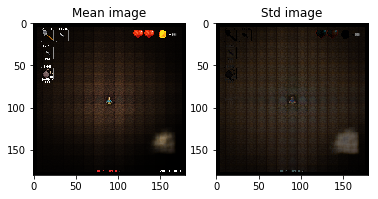

In [5]:
if usingResNet:
    meanImage = np.load("data/stats/dsetMean_ResNet.npy")
    stdImage = np.load("data/stats/dsetStd_ResNet.npy")
else:
    meanImage = np.load("data/stats/dsetMean.npy")
    stdImage = np.load("data/stats/dsetStd.npy")
plt.subplot(121)
plt.imshow(np.array(np.round(meanImage), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(stdImage), dtype=np.uint8))
plt.title("Std image")
# get channel means formatted like tensors
channelMeans = meanImage.transpose((2,0,1)).mean(axis=(1,2)) / 255
channelStds = meanImage.transpose((2,0,1)).std(axis=(1,2)) / 255

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(channelMeans, channelStds)
        ])

In [6]:
windowName = "Crypt of the NecroDancer"

env = GameEnv(windowName, 0.36, usingResNet)
agent = CloningAgent(model, transform, gamma=0.99)

# Train the model using policy gradients

In [7]:
running_reward = 15
log_interval = 20
rewardsOverTime = []
modelsFolder = "models/normal/PG_deeperquads_preinit2"

In [8]:
print("Move the windows taskbar!")
time.sleep(4) # activate the game window during this
for i_episode in range(102):
    state = env.reset()
    t, timeSinceReward, totalReward = 0, 0, 0
    while timeSinceReward < 70:  # Don't infinite loop while learning
        action = agent.sampleAction(state, verbose=(t%100==0))
        state, reward, done = env.step(action)
        if reward != 0:
            timeSinceReward = 0
            totalReward += reward
#             print("Got reward {}.".format(reward))
        agent.rewards.append(reward)
        aborted = win32gui.GetWindowText(win32gui.GetForegroundWindow()) != windowName
        if aborted or done:
            break
        timeSinceReward += 1
        t += 1
    if aborted:
        print("Game window no longer active. Stopping training.")
        break
    
    print('finishing episode...')
    running_reward = running_reward * 0.95 + totalReward * 0.05
    agent.finishEpisode()
    rewardsOverTime.append(totalReward)
    
    print('Episode {}\tLast reward: {:5d}\tAverage reward: {:.2f}'.format(
            i_episode, totalReward, running_reward))
    if i_episode % log_interval == 0:
        torch.save(agent.model.state_dict(), "{}/{}.pt".format(modelsFolder, i_episode))

Move the windows taskbar!
tensor([[-0.4021, -0.6783,  1.8085, -1.6911]])
tensor([[-0.7362, -1.8677,  6.4105,  6.2492]])
finishing episode...
Episode 0	Last reward:   118	Average reward: 20.15
tensor([[-0.7148, -0.1517,  1.3059, -1.0596]])
tensor([[-3.4140,  4.1119, -2.9928, -6.4987]])
finishing episode...
Episode 1	Last reward:    34	Average reward: 20.84
tensor([[-1.1160, -0.2660,  2.0432, -1.2103]])
tensor([[-2.6227,  4.0274, -4.9038, -1.3507]])
finishing episode...
Episode 2	Last reward:    88	Average reward: 24.20
tensor([[-1.5492,  0.6141,  1.3852, -1.1342]])
tensor([[ 1.2423, -0.6056, -1.2779,  0.5202]])
finishing episode...
Episode 3	Last reward:    84	Average reward: 27.19
tensor([[-1.6138,  0.9327,  1.1263, -0.8320]])
tensor([[-4.6943,  5.1144, -7.4395,  0.2685]])
finishing episode...
Episode 4	Last reward:    38	Average reward: 27.73
tensor([[-1.5891,  0.8317,  1.1037, -0.7263]])
tensor([[-1.0886,  3.6945, -5.4437, -3.3804]])
finishing episode...
Episode 5	Last reward:    88	

Episode 59	Last reward:     0	Average reward: 6.55
tensor([[ 28.3635, -25.3710, -30.3958,   0.3656]])
finishing episode...
Episode 60	Last reward:     0	Average reward: 6.22
tensor([[ 28.4850, -25.4552, -30.8077,   0.4642]])
finishing episode...
Episode 61	Last reward:     0	Average reward: 5.91
tensor([[ 28.7107, -25.6861, -30.8806,   0.4357]])
finishing episode...
Episode 62	Last reward:     0	Average reward: 5.61
tensor([[ 28.8188, -25.7680, -31.1458,   0.5350]])
finishing episode...
Episode 63	Last reward:     0	Average reward: 5.33
tensor([[ 29.0326, -25.9701, -31.2432,   0.4855]])
finishing episode...
Episode 64	Last reward:     0	Average reward: 5.07
tensor([[ 29.1446, -26.0617, -31.4758,   0.5116]])
finishing episode...
Episode 65	Last reward:     0	Average reward: 4.81
tensor([[ 29.2653, -26.1687, -31.6278,   0.5330]])
finishing episode...
Episode 66	Last reward:     0	Average reward: 4.57
tensor([[ 29.4184, -26.3422, -31.7633,   0.6315]])
finishing episode...
Episode 67	Last 

In [9]:
with open("{}/rewards.txt".format(modelsFolder), "w+") as rewardsFile:
    for reward in rewardsOverTime:
        rewardsFile.write("{}\n".format(reward))

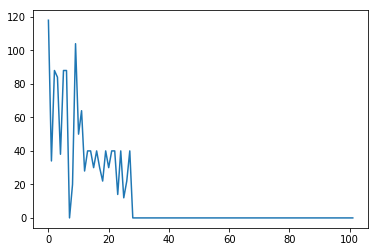

In [10]:
plt.plot(rewardsOverTime)
# plt.axis([0, 135, -40, 200])
plt.show()

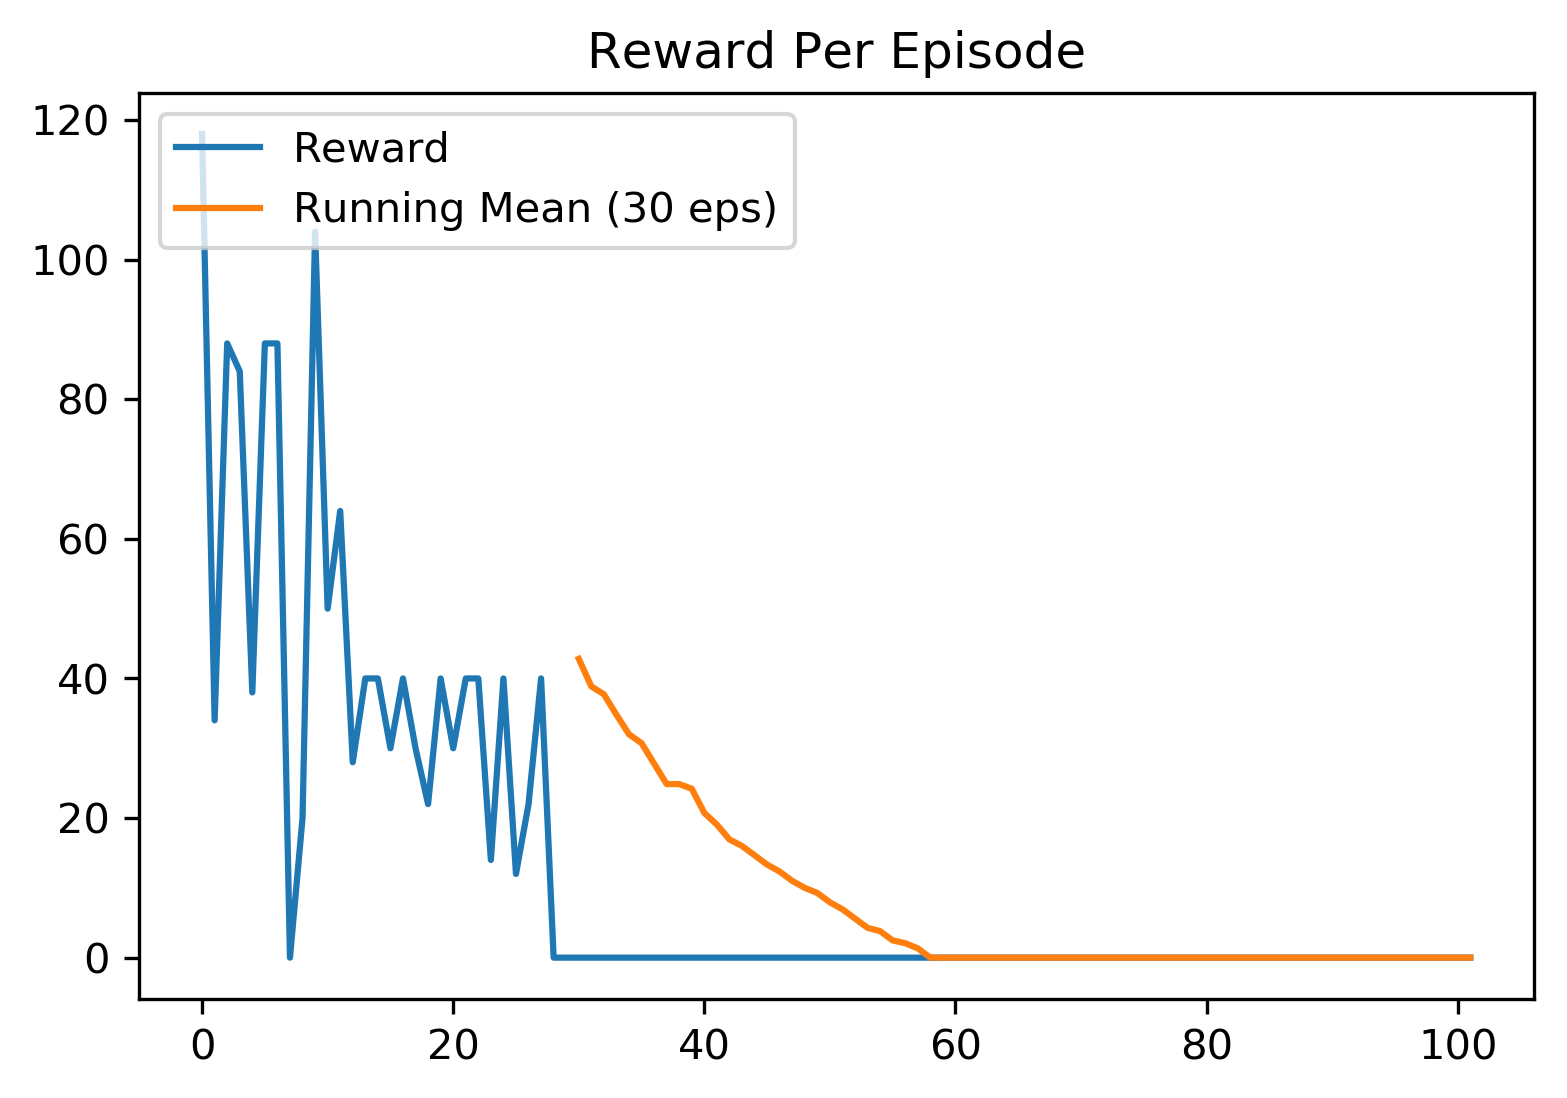

In [11]:
avgs = []
N = 30
for i in range(N):
    avgs.append(None)
    
for i in range(N, len(rewardsOverTime[:102])):
    avgs.append(sum(rewardsOverTime[i-N:i])/N)
plt.figure(dpi=300)
plt.plot(rewardsOverTime[:102],label="Reward")
plt.plot(avgs,label="Running Mean (30 eps)")
plt.legend(loc="upper left")
plt.title("Reward Per Episode")
# plt.axis([0, 120, -40, 200])
plt.savefig('demos/normal/PG_deeperquads_preinit2.png')
plt.show()


# Run the model greedily after training

In [12]:
print("Move the windows taskbar!")
with torch.no_grad():
    time.sleep(4) # activate the game window during this
    state = env.reset()
    while win32gui.GetWindowText(win32gui.GetForegroundWindow()) == windowName: # exit on window unfocus
        actionScores = agent.getActionScores(state)
#         print(actionScores)
        action = np.argmax(actionScores.data.cpu().numpy()[0])
        state, reward, done = env.step(action)
#         time.sleep(0.4)
        if reward != 0:
            print("Got reward {}.".format(reward))
        
print("Game window no longer active. Exiting.")

Move the windows taskbar!
Got reward 410.
Game window no longer active. Exiting.
